In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as model_selection
from sklearn.metrics import balanced_accuracy_score
import numpy as np
np.random.seed(42)
from collections import Counter
import matplotlib.pyplot as plt
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

**Data Generation:**
Here, we will use numpy.random.multivariate_normal to generate synthetic 2D data sets from the bivariate normal distributions defined by the means, covariances, and sizes.

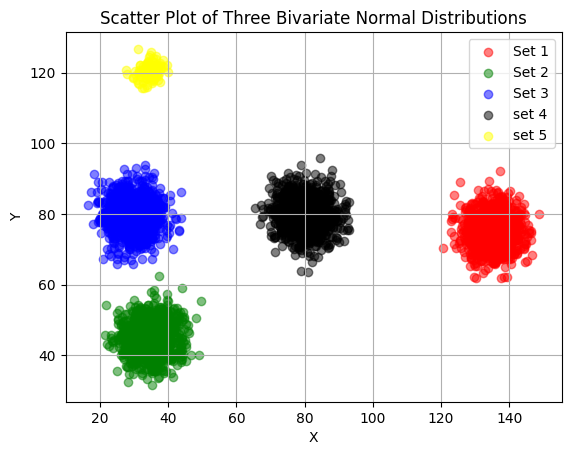

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters for the three bivariate normal distributions
means = [[135, 75], [35, 45], [30, 80],[80,80],[35,120]]
covariances = [[[20, 0], [0, 20]], [[20, 0], [0, 20]],[[20, 0], [0, 20]],[[20, 0], [0, 20]], [[5, 0], [0, 5]]]
sizes = [1000, 1000,1000,1000, 100]

# Generate 2D data from the three bivariate normal distributions
data_sets = [np.random.multivariate_normal(means[i], covariances[i], sizes[i]) for i in range(5)]
# print(data_sets)
# Plot the scatter plot for each data set
colors = ['red', 'green', 'blue','black','yellow']
labels = ['Set 1', 'Set 2', 'Set 3','set 4','set 5']

for i in range(5):
    plt.scatter(data_sets[i][:, 0], data_sets[i][:, 1], alpha=0.5, color=colors[i], label=labels[i])

# Add labels and legend
plt.title('Scatter Plot of Three Bivariate Normal Distributions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X=np.concatenate(data_sets)
X=pd.DataFrame(X)


Here, we will find roughly Kmean center by runing Kmeans algorithm (just 5 interation) to get rough idea of clusteres

In [ ]:
km1 =KMeans(n_clusters=5, max_iter=5)
y_predicted = km1.fit_predict(X)
B=km1.cluster_centers_
B=pd.DataFrame(B)
print("Roughly kmean center :", B)

Roughly kmean center :             0           1
0  135.148413   75.254832
1   29.807454   79.763171
2   80.097365   79.862657
3   34.951623   44.990753
4   34.422825  120.442112


First, we  roughly find the solution using k-means++ and get an approximate center, called B. This method sets up cluster centers in a clever way, usually giving better results than random setup.\
Next, we pick a subset of data points using importance sampling based on the sensitivity. Importance sampling lets us choose points with probabil-
ities tied to their influence on clustering. The sensitivity limit ensures the chosen subset represents the original data well.
  

In [ ]:
import numpy as np
import pandas as pd

def aglo2(X, B, k):
    a = 16 * (np.log(k) + 2)
    Bi = [[] for _ in range(len(B))]
    X_dist = []
    X_min_bindx = []

    for i in range(len(X)):
        min_dist = 10000000000
        min_index = -1
        Xi = X.iloc[i].to_numpy()

        for j in range(len(B)):
            bj = B.iloc[j].to_numpy()
            dist = np.sum((Xi - bj) ** 2)

            if dist < min_dist:
                min_dist = dist
                min_index = j

        Bi[min_index].append(X.iloc[i].to_numpy())
        X_dist.append(min_dist)
        X_min_bindx.append(min_index)

    c_phi = 0

    for i in range(len(X)):
        c_phi += X_dist[i]

    S_x = []
    sigma_s = 0

    for i in range(len(X)):
        si = 0
        si += (a * X_dist[i]) / (c_phi)
        b_index = X_min_bindx[i]
        bi = B.iloc[b_index].to_numpy()
        temp_sum = 0

        for j in range(len(Bi[b_index])):
            temp_sum += np.sum((bi - Bi[b_index][j]) ** 2)

        si += (2 * a * temp_sum) / (len(Bi[b_index]) * c_phi)
        si += 4 * len(X) / len(Bi[b_index])
        S_x.append(si)
        sigma_s += si

    p_x = []
    for i in range(len(X)):
        p_x.append(S_x[i] / sigma_s)
    subsets=[]
    for m in [20,25,30,35,40,45,50,55,60,70,80,90,100]:
      selected_indices = np.random.choice(len(X), m, replace=False, p=p_x)
      select_set=X.iloc[selected_indices]
      select_set['w']=[1/(p_x[i]*m) for i in selected_indices]
      subsets.append(select_set)
    # print(w_x)
    return subsets

This cost function will calculet Kmeans cost of data points if Kmeans center is given.

In [ ]:
def cost(X,centers):
  sum=0
  for i in range(len(X)):
    point1=X.iloc[i].to_numpy()
    cost_i=100000
    for j in range(len(centers)):
      point2=centers[j]
      if(np.sum((point1 - point2)**2)<cost_i):
        cost_i=np.sum((point1 - point2)**2)
    sum+=cost_i
  return sum

In [ ]:
Here, this function will find Kmeans center of weighted points.

In [ ]:
import numpy as np

def weighted_kmeans(X, k, weights, max_iters=100):
    # Randomly initialize centroids
    X=X.to_numpy();
    weights=weights.to_numpy()
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        distances=np.full(len(X), 0)
        labels=np.full(len(X), 0)
        for i in range(len(X)):
          dist= np.sqrt(np.sum((centroids - X[i])**2, axis=1))
          labels[i] = np.argmin(dist)




        # Update centroids based on the weighted mean of points in each cluster
        new_centroids = np.array([
            np.average(X[labels == i], axis=0, weights=weights[labels == i])
            if np.sum(weights[labels == i]) != 0  # Check if there are points in the cluster
            else np.zeros(X.shape[1])  # If no points, set the centroid to zero
            for i in range(k)
        ])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids

This code snippet calculates the cost error for different subsets generated by the aglo2 function. It initializes a list cost_error1 with 13 elements, each representing the cost error for a specific subset size. Then, it iterates 10 times, generating subsets using the aglo2 function and computing the cost error for each subset. Finally, it averages the cost errors over the 10 iterations for each subset size.

In [ ]:
cost_error1=[0]*13;
for _ in range(10):
  subsets=aglo2(X.copy(),B,5)
  subsets

  km_full =KMeans(n_clusters=5)
  y_full = km_full.fit_predict(X)
  cost_org=km_full.inertia_
  for i,s in enumerate(subsets):
    km_sub=KMeans(n_clusters=5)
    km_sub.fit_predict(s.iloc[:, :-1],sample_weight=s['w'])
    sub_center=km_sub.cluster_centers_
    cost_by_sub_center=cost(X,sub_center)
    error=(cost_by_sub_center- cost_org)/cost_org * 100
    cost_error1[i]+=error
for i in range(len(cost_error1)):
  cost_error1[i]/=10


In [ ]:
cost_error1

[220.78891704316933,
 38.71935898786852,
 15.399361005576768,
 19.380708482849915,
 11.67960265378218,
 19.053916415368946,
 12.022092734767828,
 10.556933003655349,
 8.380097476542984,
 6.689091654058437,
 9.696810477560085,
 5.556399318753949,
 4.8258758083357]

Here we will do same things, but we will do use random sampling for suset generation not by algo2.

In [ ]:
cost_error3=[0]*13;
for _ in range(10):
  km_full =KMeans(n_clusters=5)
  y_full = km_full.fit_predict(X)
  cost_org=km_full.inertia_
  for i,m in enumerate ([20,25,30,35,40,45,50,55,60,70,80,90,100]):
    km_sub=KMeans(n_clusters=5)
    km_sub.fit_predict(X.sample(n=m))
    sub_center=km_sub.cluster_centers_
    cost_by_sub_center=cost(X,sub_center)
    error=(cost_by_sub_center- cost_org)/cost_org * 100
    cost_error3[i]+=error
for i in range(len(cost_error3)):
  cost_error3[i]/=10
cost_error3

[89.94865933557256,
 47.35143341978275,
 62.30337643933905,
 68.08547502967727,
 50.10839949018357,
 27.0338567744108,
 48.3596672608956,
 6.161352287928555,
 41.739076617944825,
 23.229106699065774,
 12.634811165086255,
 23.770408934547,
 3.83165984323836]

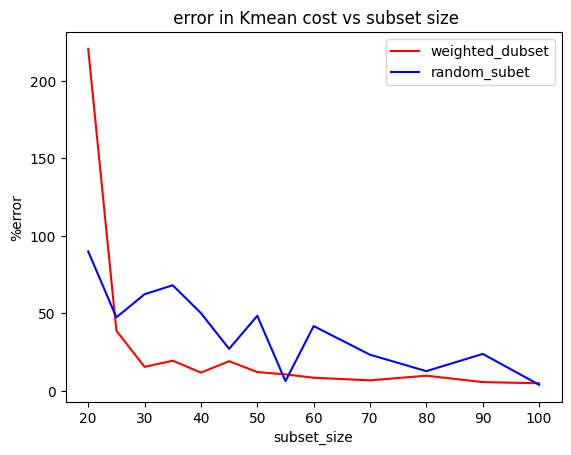

In [ ]:
import matplotlib.pyplot as plt

# Example data
x1 =cost_error1

x3 =cost_error3
y = [20,25,30,35,40,45,50,55,60,70,80,90,100]

# Plot x1 in red
plt.plot(y, x1, color='red', label='weighted_dubset')

# # Plot x2 in green
# plt.plot(y, x2, color='green', label='subset_using_dist')
# Plot x2 in green
plt.plot(y, x3, color='blue', label='random_subet')

# Customize the plot
plt.xlabel('subset_size')
plt.ylabel('%error')
plt.title(' error in Kmean cost vs subset size')
plt.legend()

# Show the plot
plt.show()